# Image classification with `skorch`

**Make sure you look at [`Image classification`](Image_classification.ipynb) before coming here.**

**I recommend using the notebook [`Image classification with PyTorch`](Image_classification_with_Scikit-Learn.ipynb) instead of this one.**

We'll use `Pytorch` together with supporting libraries `tensorlayers` and `skorch` to train a classifier for fossil images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## The fossil dataset

Let's generate a workflow to classify images using a CNN.
We'll make use of a collection of functions in `utils.py` to help process the images found in the `data/fossils` folder.

In [147]:
import numpy as np

ds = np.DataSource('../data/')

X = np.load(ds.open('https://geocomp.s3.amazonaws.com/data/fossils_X.npy', mode='rb'))
y = np.load(ds.open('https://geocomp.s3.amazonaws.com/data/fossils_y.npy', mode='rb'))

In [148]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [149]:
X_train.shape

(527, 1024)

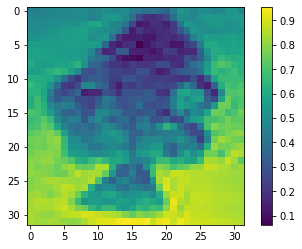

In [153]:
plt.imshow(X_train[0].reshape(32,32))
plt.colorbar()

## Note to instructors

Depending on the level and interests of the group, and the time available, and what you've covered so far, it might be a good idea to pause here and check that everyone is comfortable with convolution. Not necessarily exactly how it works, alrthough that's fairly straightforward, but at least the concept and purpose of it.

We're focused on convolution for **feature extraction**, as opposed to filtering, so keep examples focused on that. Edge detection is a pretty intuitive topic.

For example, you could do a demo like these:

In [154]:
# 1D example: a step.
signal = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

kernel = [1, 0, -1]

np.convolve(signal, kernel, mode='valid')  # Can talk about effect of mode='same' or 'full' too

# The 'edge' is highlighted, flat stuff is just 0's.

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

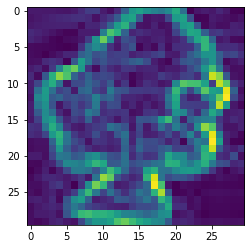

In [155]:
# 2D example
from scipy.signal import convolve2d

kernel = np.array([[-1, 0, 1],  # This is one of the two Sobel edge detection kernels.
                   [-2, 0, 2],  # The other one is the transpose of this.
                   [-1, 0, 1]])

# Look at these individually too.
a = convolve2d(X_train[0].reshape(32,32), kernel, mode='valid')
b = convolve2d(X_train[0].reshape(32,32), kernel.T, mode='valid')
out = np.sqrt(a**2 + b**2)

plt.imshow(out)

## A convolutional neural network with skorch

Here's a nice resource on ConvNets: https://cs231n.github.io/convolutional-networks/

We need to encode the labels:

In [156]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(np.append(y_train, y_test))

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

Skorch can use NumPy arrays, which is nice, but for they have to be single precision (i.e. 32-bit floats) to be compatible with PyTorch and GPUs.

In [157]:
X_train = X_train.reshape(-1, 1, 32, 32).astype(np.float32)
X_test = X_test.reshape(-1, 1, 32, 32).astype(np.float32)

PyTorch will need to know the device we're computing on:

In [158]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [159]:
from torch import nn
from collections import OrderedDict

class FossilNet(torch.nn.Module):
    def __init__(self):
        super(FossilNet, self).__init__()

        # Note that most activations, maxpooling, and dropout are commutative.
        # Pooling reduces dimensions, so doing it first speeds things up.
        # BN is generally not commutative; some place it before activation, some after.
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm2d(24),
        )

        # Another way to define a layer.
        self.layer2 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(24, 8, kernel_size=3, padding=1)),
            ('pool', nn.MaxPool2d(kernel_size=2)),
            ('relu', nn.ReLU()),
            ('bn', nn.BatchNorm2d(8)),])
        )
        
        self.drop_out = nn.Dropout(p=0.25)

        # The last component is an ordinary 'fully connected' neural network.
        # It can also have multiple layers, like any 'vanilla' neural net.
        # The shape comes from 32 x 32 images reduced by convolutions & pooling.
        self.fc = nn.Linear(8 * 8 * 8, 3)
        self.smax = nn.Softmax(dim=-1)  # Not required for pure PyTorch,
                                        # because Criterion includes it.
        
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.drop_out(x)
        x = self.fc(x)
        x = self.smax(x)
        return x

net = FossilNet().to(device)

In [160]:
net

FossilNet(
  (layer1): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (conv): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop_out): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (smax): Softmax(dim=-1)
)

In [161]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint

# Callbacks.
cp = Checkpoint(dirname='skorch_cp')
es = EarlyStopping(monitor='valid_loss', patience=9)

cnn = NeuralNetClassifier(net,
                          max_epochs=100,
                          batch_size=100,
                          lr=0.002,
                          optimizer=torch.optim.Adam,
                          callbacks=[cp, es],
                          )

**Note** `skorch` will do validation internally on 20% of the input data. You can turn this off with `train_split=None`, or use a predefined dataset, for example like so (from [the docs](https://skorch.readthedocs.io/en/stable/user/FAQ.html#i-already-split-my-data-into-training-and-validation-sets-how-can-i-use-them)):

```python
from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split
from skorch.dataset import Dataset

X_train, X_test, y_train, y_test = train_test_split(X, y)

valid_ds = Dataset(X_test, y_test)

net = NeuralNet(
    ...,
    train_split=predefined_split(valid_ds)
)

net.fit(X_train, y_train)
```

In [162]:
cnn.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        1.0437       0.3208        1.0940     +  0.0932
      2        0.8147       0.3208        1.1298        0.0830
      3        0.7031       0.3679        1.1803        0.0832
      4        0.6329       0.4057        1.1456        0.0808
      5        0.6348       0.5094        1.1055        0.0833
      6        0.5818       0.5566        1.0403     +  0.0834
      7        0.5520       0.5943        0.9783     +  0.0807
      8        0.5125       0.6038        0.9396     +  0.0787
      9        0.4782       0.6038        0.8841     +  0.0778
     10        0.4414       0.6415        0.8405     +  0.0775
     11        0.4225       0.6792        0.7906     +  0.0841
     12        0.3862       0.6698        0.8889        0.0796
     13        0.3623       0.6792        0.7547     +  0.0759
     14        0.3414       0.6887        0.7730       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=FossilNet(
    (layer1): Sequential(
      (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer2): Sequential(
      (conv): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU()
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (drop_out): Dropout(p=0.25, inplace=False)
    (fc): Linear(in_features=512, out_features=3, bias=True)
    (smax): Softmax(dim=-1)
  ),
)

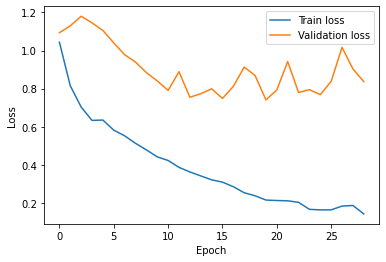

In [163]:
plt.plot(cnn.history[:, 'train_loss'], label='Train loss')
plt.plot(cnn.history[:, 'valid_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [164]:
cnn.load_params(checkpoint=cp)

y_pred = cnn.predict(X_val)

In [165]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77        29
           1       0.71      0.83      0.76        29
           2       0.62      0.53      0.57        30

    accuracy                           0.70        88
   macro avg       0.70      0.71      0.70        88
weighted avg       0.70      0.70      0.70        88



In [166]:
np.set_printoptions(precision=4, suppress=True)

y_probs = cnn.predict_proba(X_val)
y_probs[:10]

array([[0.2544, 0.0003, 0.7454],
       [0.028 , 0.8166, 0.1554],
       [0.0387, 0.8613, 0.0999],
       [0.0386, 0.8994, 0.062 ],
       [0.106 , 0.3705, 0.5236],
       [0.4005, 0.0007, 0.5989],
       [0.0156, 0.9216, 0.0628],
       [0.0191, 0.6031, 0.3777],
       [0.983 , 0.    , 0.0169],
       [0.9835, 0.0012, 0.0153]], dtype=float32)

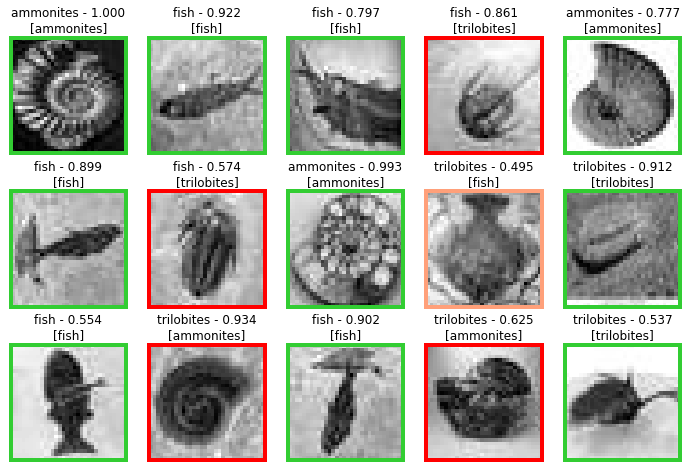

In [167]:
import mlutils

mlutils.visualize(X_val, y_val, y_probs,
                ncols=5, nrows=3,
                shape=(32, 32),
                classes=encoder.classes_
               )

## The kernels

It is possible to inspect and visualize the weights in the model's layers:

In [168]:
w1 = cnn.module_.layer1[0].weight.detach().numpy()
w1.shape

(24, 1, 3, 3)

In [169]:
ma = np.percentile(w1, 99)
ma

0.32908511906862253

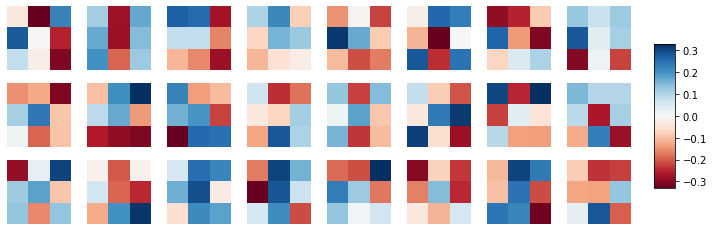

In [170]:
ma = np.percentile(w1, 99)

fig, axs = plt.subplots(nrows=3, ncols=8, figsize=(12, 4))
for w, ax in zip(w1, axs.ravel()):
    im = ax.imshow(np.sum(w, axis=0), vmin=-ma, vmax=ma, cmap='RdBu')
    ax.axis('off')
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.25, 0.025, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)

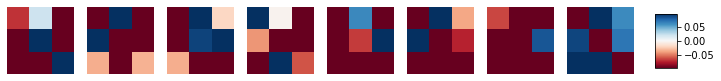

In [171]:
w2 = cnn.module_.layer2[0].weight.detach().numpy()
ma = np.percentile(w2, 99)

fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(12, 1.5))
for w, ax in zip(w2, axs.ravel()):
    im = ax.imshow(np.sum(w, axis=0), vmin=-ma, vmax=ma, cmap='RdBu')
    ax.axis('off')
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.25, 0.025, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)

## Using grid search with this network

In theory, you can also use `scikit-learn` training flow objects to train robust models such as `GridSearchCV`.

This is potentially cool, but I am not 100% certain that the models are initializing for each model. If you want to use this, I suggest reading the `skorch` docs carefully.

In [175]:
from sklearn.model_selection import GridSearchCV

cnn = NeuralNetClassifier(net,
                          max_epochs=10,
                          batch_size=100,
                          optimizer=torch.optim.Adam,
                          train_split=None,  # Not needed in CV.
                          )

params = {
    'lr': [0.001, 0.003, 0.01],                     # Learning rate.
    'optimizer__weight_decay': [0.001, 0.01, 0.1],  # L2 regularization.
}

gs = GridSearchCV(cnn, params, refit=False, cv=3, scoring='f1_weighted')

gs.fit(X_train, y_train)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.2487  0.0685
      2        0.2091  0.0641
      3        0.1881  0.0576
      4        0.1833  0.0569
      5        0.1551  0.0572
      6        0.1565  0.0569
      7        0.1491  0.0567
      8        0.1505  0.0578
      9        0.1365  0.0569
     10        0.1210  0.0582
  epoch    train_loss     dur
-------  ------------  ------
      1        0.3995  0.0619
      2        0.2947  0.0627
      3        0.3268  0.0618
      4        0.3106  0.0576
      5        0.2587  0.0583
      6        0.2584  0.0582
      7        0.2225  0.0588
      8        0.2103  0.0583
      9        0.2045  0.0606
     10        0.1888  0.0545
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4004  0.0519
      2        0.3339  0.0557
      3        0.3299  0.0559
      4        0.2931  0.0628
      5        0.2625  0.0623
      6        0.2530  0.0626
      7        0.2269  0.0545
      8   

      7        0.3667  0.0679
      8        0.2965  0.0736
      9        0.3005  0.0697
     10        0.2821  0.0650
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0931  0.0621
      2        0.7526  0.0675
      3        0.6240  0.0719
      4        0.5617  0.0683
      5        0.4545  0.0643
      6        0.4069  0.0576
      7        0.3531  0.0567
      8        0.3035  0.0566
      9        0.2891  0.0601
     10        0.2603  0.0668
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1386  0.0668
      2        0.7622  0.0630
      3        0.7296  0.0607
      4        0.5102  0.0570
      5        0.4752  0.0575
      6        0.4206  0.0581
      7        0.3479  0.0643
      8        0.3028  0.0689
      9        0.2590  0.0606
     10        0.2274  0.0632
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1981  0.0530
      2        0.8362  0.0574
      3        0.6490  0.0569
      4   

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=FossilNet(
    (layer1): Sequential(
      (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True...
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU()
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (drop_out): Dropout(p=0.25, inplace=False)
    (fc): Linear(in_features=512, out_features=3, bias=True)
    (smax): Softmax(dim=-1)
  ),
),
             param_grid={'lr': [0.001, 0.003, 0.01],
                         'optimizer__weight_decay': [0.001, 0.01, 0.1]},
             refit=False, scoring='f1_weighted')

In [176]:
print(gs.best_score_, gs.best_params_)

0.8606193874307436 {'lr': 0.001, 'optimizer__weight_decay': 0.1}


## What next?

At this point you might:

- Continue exploring model variations to find the best performance.
- Check the model's performance against the test data.
- Train the model on all your data.
- Save the model to disk for use later or by someone else.
- Make an app or API or some way for others to make inferences.

## Model persistence

The easiest way to save a model is to `pickle` the trained model object.

In [177]:
import pickle

# Saving.
with open('fossil_classifier.pkl', 'wb') as f:
    pickle.dump(cnn, f)

# Loading.
with open('fossil_classifier.pkl', 'rb') as f:
    cnn = pickle.load(f)

In [178]:
cnn.initialize()
cnn.predict(X_val)

array([2, 1, 1, 1, 2, 2, 1, 1, 0, 0, 0, 2, 2, 1, 2, 0, 1, 0, 2, 1, 1, 2,
       2, 1, 1, 0, 0, 1, 1, 0, 2, 1, 2, 1, 0, 2, 2, 1, 0, 1, 2, 1, 1, 0,
       0, 2, 0, 0, 1, 2, 0, 2, 0, 1, 1, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0,
       1, 2, 0, 2, 2, 2, 1, 0, 2, 0, 0, 2, 1, 1, 1, 0, 2, 0, 1, 2, 1, 2])

---

&copy; 2022 Agile Scientific